# Beam parameter scan through a foil
K. Sjobak, October 23rd 2018, October 2025

Scan beam parameters at focal point, computing the twiss parameters modification (incl. emittance growth) by a scattering foil upstream of the lens.

## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#Setup MiniScatter
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)

import miniScatterDriver
import miniScatterScanner

#import os
#runFolder = os.getcwd()
#tmpFolder = os.path.join(runFolder,"tmp")
#if not os.path.exists(tmpFolder):
#    print("Making folder '{}'".format(tmpFolder))
#    os.mkdir(tmpFolder)

# General simulation setup

In [3]:
NUMEVENTS = 100000
NUMBETA = 10
TRYLOAD = False
NUM_THREADS=10

In [4]:
def TwissDrift(beta_in:float, gamma_in:float, alpha_in:float, L:float | np.typing.ArrayLike ) -> tuple:
    "Propagate the initial Twiss parameters beta_in, gamma_in, alpha_in over a distance L (positive or negative, can be a numpy array) of free-space drift."
    beta_out  = beta_in + L**2 * gamma_in - 2*L*alpha_in
    gamma_out =                  gamma_in
    alpha_out =         -    L * gamma_in     + alpha_in
    return (beta_out, gamma_out, alpha_out)

def getGamma(beta_in:float, alpha_in:float):
    "Compute Twiss parameter Gamma from parameters Beta and Alpha"
    return (1.0 + alpha_in**2)/beta_in

def runSimulations(eps_0x=1.0, eps_0y=1.0, alpha_0=-5.0, THICK=3e-3, MAT="G4_MYLAR", N=1000000, N_beta=10, L0=0.202):
    """
    Run a simulation of the effect on the Twiss parameters some distance after a scattering foil,
    given the emittance [um] and alpha_0 at this point had the foil not been there,
    as well as the thickness of the foil [mm] and the foil material.
    """

    #System parameters
    #L = 0.202 #[m] Capillary-to-foil distance
    #Lcap = 0.015 #[m] Capillary length
    Lcap = 0.020 #[m] Capillary length
    L = L0 + Lcap/2.0 #We actually care about the middle of the capillary

    matstr = MAT
    if MAT == "G4_MYLAR":
        matstr = "Mylar"
    elif MAT == "G4_KAPTON":
        matstr = "Kapton"
    plottitle = "{0:.1f} $\\mu$m {1}, $\\alpha_0={2:.1f}$, $\\varepsilon_0 = {3:.1f}:{4:.1f}$ [$\\mu$m], $L_0$={4:.1f} [mm]".\
                                                  format(THICK*1000, matstr, alpha_0, eps_0x,eps_0y, L0*1e3)

    #Simulation parameters
    baseSimSetup = {}
    baseSimSetup["N"]       = N
    baseSimSetup["DIST"]    = L*1000 #[mm] #Detector distance = capillary center position
    baseSimSetup["ENERGY"]  = 200.0 #[MeV]
    baseSimSetup["ZOFFSET"] = -THICK/2 - 1e-7 #[m] Where the beam starts - target centered on z=0
    baseSimSetup["ZOFFSET_BACKTRACK"] = True
    # Use single-scattering electromagnetics for more accurate scattering angles in thin foils
    baseSimSetup["PHYS"] = "QGSP_BERT__SS"
    baseSimSetup["QUICKMODE"] = True
    baseSimSetup["MINIROOT"]  = True   #Skip TTRees in the .root files
    baseSimSetup["MAT"] = MAT
    baseSimSetup["THICK"] = THICK
     # Include all charged particles with E > 0.95*E_0 (default) for the "cutoff" twiss parameters
    baseSimSetup["CUTOFF_RADIUS"] = 1.0 #[mm]
    
    #baseSimSetup["OUTFOLDER"] = tmpFolder
    # Simulations are running sequentially, so they can all use the same filename.
    # The .root postfix gets added automatically by MiniScatter.
    #baseSimSetup["OUTNAME"]   = "output"
    
    #Store the .root files in a subfolder from MiniScatter/examples, to be easy to find
    #baseSimSetup["OUTFOLDER"]=os.path.join(os.getcwd(),"Foil_BeamParameterScan")

    #Assume electron beam
    gamma_rel = baseSimSetup["ENERGY"]/0.511
    beta_rel  = np.sqrt(gamma_rel**2 - 1.0) / gamma_rel;

    print ("plottile  = '"+plottitle+"'")
    print ("gamma_rel =", gamma_rel)
    print ("beta_rel  =", beta_rel)
    
    #Make output folder for plots
    dirpath="plots/beamParamScan_alpha0={0:.1f}_eps0={1:.1f}:{2:.1f}_THICK={3}_MAT={4}_Npoints={5}".\
        format(alpha_0,eps_0x,eps_0y,THICK,MAT,N_beta)
    
    if not os.path.exists("plots"):
        print()
        print("Making folder 'plots'")
        os.mkdir("plots")
    
    try:
        print()
        print("Making folder '"+dirpath+"'")
        os.mkdir(dirpath)
    except FileExistsError:
        print("Aready there! nuking it.")
        import shutil
        shutil.rmtree(dirpath)
        os.mkdir(dirpath)
    print()

    #This is what we want to scan
    # Vacuum beta function in lens center
    beta_0   = np.logspace(np.log10(0.005),np.log10(1.50),N_beta) #[m]

    #Computed parameters
    eps_x   = np.empty_like(beta_0) #Measured in lens center, with scattering and filtering
    beta_x  = np.empty_like(beta_0)
    alpha_x = np.empty_like(beta_0)
    sigma_x = np.empty_like(beta_0)

    eps_y   = np.empty_like(beta_0) #Measured in lens center, with scattering and filtering
    beta_y  = np.empty_like(beta_0)
    alpha_y = np.empty_like(beta_0)
    sigma_y = np.empty_like(beta_0)

    sigma_0x   = np.empty_like(beta_0) #Vacuum size in lens center
    sigma_0y   = np.empty_like(beta_0)
    beta_foil  = np.empty_like(beta_0) #Backpropagated to foil
    alpha_foil = np.empty_like(beta_0)


    sPos = np.linspace(-1.25*L,0.25*L,200)

    #Setup scan
    COVAR = []
    for i in range(len(beta_0)):
        print()
        
        gamma_0 = getGamma(beta_0[i],alpha_0)
        (beta_foil[i],gamma_foil,alpha_foil[i]) = TwissDrift(beta_0[i],gamma_0,alpha_0,-L)

        COVAR_ = (eps_0x,beta_foil[i],alpha_foil[i],eps_0y,beta_foil[i],alpha_foil[i])

        sigma_0x[i] = np.sqrt(eps_0x*beta_0[i]*1e6/(gamma_rel*beta_rel))
        sigma_0y[i] = np.sqrt(eps_0y*beta_0[i]*1e6/(gamma_rel*beta_rel))

        print("Setting up simulation for beta_0 =", beta_0[i], "[m] -> sigma_0 =", sigma_0x[i], "and", sigma_0y[i], "[um]")

        COVAR.append(COVAR_)

    #Run the scan (in parallel)
    (twiss_scan, numpart_scan, objects_scan, analysisOutput_scan) =\
        miniScatterScanner.ScanMiniScatter("COVAR",COVAR,\
                                           baseSimSetup, COMMENT="beta_scan",\
                                           tryLoad=TRYLOAD, NUM_THREADS=NUM_THREADS)
    print()
    print()

    #Analyze the scan data
    
    #Create figures for plotting the beam development as function of s
    default_size = plt.rcParams.get('figure.figsize')
    double_width = np.asarray(default_size)
    double_width[0] *= 2
    fig1 = plt.figure(figsize=double_width)
    plt.subplots_adjust(left=0.06,right=0.98)
    fig2 = plt.figure(figsize=double_width)
    plt.subplots_adjust(left=0.06,right=0.98)


    for i in range(len(beta_0)):
        print(f"Postprocessing simulation #{i}")

        ## WHERE IS tracker_cutoff ?!?
        eps_x[i]   = twiss_scan['tracker_cutoff']['x']['eps'][i]
        beta_x[i]  = twiss_scan['tracker_cutoff']['x']['beta'][i]
        alpha_x[i] = twiss_scan['tracker_cutoff']['x']['alpha'][i]
        sigma_x[i] = np.sqrt(eps_x[i]*beta_x[i]*1e6/(gamma_rel*beta_rel))

        eps_y[i]   = twiss_scan['tracker_cutoff']['y']['eps'][i]
        beta_y[i]  = twiss_scan['tracker_cutoff']['y']['beta'][i]
        alpha_y[i] = twiss_scan['tracker_cutoff']['y']['alpha'][i]
        sigma_y[i] = np.sqrt(eps_y[i]*beta_y[i]*1e6/(gamma_rel*beta_rel))

        # No-scatter beta(s) [x/y]
        beta0_s = TwissDrift(beta_0[i],gamma_0,alpha_0,sPos)[0]

        #Scattered beta(s)
        gamma_x = getGamma(beta_x[i],alpha_x[i])
        beta_xs = TwissDrift(beta_x[i],gamma_x,alpha_x[i],sPos)[0]
        gamma_y = getGamma(beta_y[i],alpha_y[i])
        beta_ys = TwissDrift(beta_y[i],gamma_y,alpha_y[i],sPos)[0] # Scattered beta(s)

        #Plot sigma(s) for x
        plt.figure(fig1.number)

        l1 = plt.plot(sPos,np.sqrt(eps_0x*beta0_s*1e6/(gamma_rel*beta_rel)), ls="--" )[0] # No-scatter sigma
        plt.plot(0.0, np.sqrt(eps_0x*beta_0[i]*1e6/(gamma_rel*beta_rel)), 'o', color=l1.get_color())

        plt.plot(sPos,np.sqrt(eps_x[i]*beta_xs*1e6/(gamma_rel*beta_rel)),\
                 label='{0:.3g}'.format(beta_0[i]*100), ls="-",color=l1.get_color()) # Scattered sigma
        plt.plot(0.0, np.sqrt(eps_x[i]*beta_x[i]*1e6/(gamma_rel*beta_rel)), 's', color=l1.get_color())

        #Plot sigma(s) for y
        plt.figure(fig2.number)

        l1 = plt.plot(sPos,np.sqrt(eps_0y*beta0_s*1e6/(gamma_rel*beta_rel)), ls="--" )[0]  # No-scatter sigma
        plt.plot(0.0, np.sqrt(eps_0y*beta_0[i]*1e6/(gamma_rel*beta_rel)), 'o', color=l1.get_color())

        plt.plot(sPos,np.sqrt(eps_y[i]*beta_ys*1e6/(gamma_rel*beta_rel)),\
                 label='{0:.3g}'.format(beta_0[i]*100), ls="-",color=l1.get_color()) # Scattered sigma
        plt.plot(0.0, np.sqrt(eps_y[i]*beta_y[i]*1e6/(gamma_rel*beta_rel)), 's', color=l1.get_color())

        # print("Twiss (X):", twiss_scan['tracker_cutoff']['x']['eps'][i], \
        #                     twiss_scan['tracker_cutoff']['x']['beta'][i], \
        #                     twiss_scan['tracker_cutoff']['x']['alpha'][i])
        # print("Twiss (Y):", twiss_scan['tracker_cutoff']['y']['eps'][i], \
        #                     twiss_scan['tracker_cutoff']['y']['beta'][i], \
        #                     twiss_scan['tracker_cutoff']['y']['alpha'][i])
        # print("Sigma (X):",sigma_x[i], "[um]")
        # print("Sigma (Y):",sigma_y[i], "[um]")
        # print()

    ### Finish plots ###
    print("Plotting..")

    # Plot sigma(s) for x, for both no-scatter case (--) and scattered case(-)
    plt.figure(fig1.number)
    plt.title(plottitle)
    plt.axvline(-L, ls='-',color='blue')
    plt.axvspan(-Lcap/2.0, Lcap/2.0, facecolor='gray', alpha=0.25)
    plt.xlabel('s [m]')
    plt.ylabel('$\\sigma_x$ [$\\mu$m]')
    plt.legend(loc=0,ncol=4,title="$\\beta_0$ [cm], --:Vacuum, -:Scattered")
    plt.savefig(dirpath + "/" + "sigma-s.png")
    plt.ylim(0,200)
    #plt.savefig(dirpath + "/" + "sigmax-s-ZOOM.png")
    #plt.ylim(0,100)
    #plt.savefig(dirpath + "/" + "sigmax-s-ZOOM2.png")
    
    # Plot sigma(s) for y, for both no-scatter case (--) and scattered case(-)
    plt.figure(fig2.number)
    plt.title(plottitle)
    plt.axvline(-L, ls='-',color='blue')
    plt.axvspan(-Lcap/2.0, Lcap/2.0, facecolor='gray', alpha=0.25)
    plt.xlabel('s [m]')
    plt.ylabel('$\\sigma_y$ [$\\mu$m]')
    plt.legend(loc=0,ncol=4,title="$\\beta_0$ [cm], --:Vacuum, -:Scattered")
    plt.savefig(dirpath + "/" + "sigmay-s.png")
    plt.ylim(0,200)
    #plt.savefig(dirpath + "/" + "sigmay-s-ZOOM.png")
    #plt.ylim(0,100)
    #plt.savefig(dirpath + "/" + "sigmay-s-ZOOM2.png")

    #Used for a lot of vertical lines
    minEpsIdx_x = np.argmin(eps_x)
    minEpsIdx_y = np.argmin(eps_y)

    # Plot emittance(beta_0) for x/y
    plt.figure()
    plt.title(plottitle)
    l_x = plt.plot(beta_0*100,eps_x, label="$\\varepsilon_x$")[0]
    l_y = plt.plot(beta_0*100,eps_y, label="$\\varepsilon_y$")[0]
    plt.xlabel("$\\beta_{0,capillary}$ [cm]")
    plt.ylabel("$\\varepsilon_N$ [$\\mu$m]")
    plt.axhline(eps_0x,ls='--', label="$\\varepsilon_{x,0}$", color=l_x.get_color())
    plt.axhline(eps_0y,ls='--', label="$\\varepsilon_{y,0}$", color=l_y.get_color())
    plt.legend(loc=0)
    plt.axvline(beta_0[minEpsIdx_x]*100,color=l_x.get_color(),ls='--')
    plt.axvline(beta_0[minEpsIdx_y]*100,color=l_y.get_color(),ls='--')
    #plt.savefig(dirpath + "/" + "epsN-beta0.png")
    #plt.ylim(0,max(eps_x[-1],eps_y[-1])*1.2)
    #plt.savefig(dirpath + "/" + "epsN-beta0-ZOOM.png")
    plt.yscale('log')

    plt.figure()
    ax1 = plt.gca()
    plt.title(plottitle)
    l_bf = plt.plot(beta_0*100,beta_foil*100)[0]
    plt.ylabel("$\\beta_{foil} [cm]$")
    plt.xlabel("$\\beta_{0,capillary}$ [cm]")
    plt.axvline(beta_0[minEpsIdx_x]*100,color=l_x.get_color(),ls='--')
    plt.axvline(beta_0[minEpsIdx_y]*100,color=l_y.get_color(),ls='--')
    plt.yscale('log')
    ax2=plt.twinx()
    l_af = ax2.plot(beta_0*100,alpha_foil, ls="--")[0]
    ax2.set_ylabel("$\\alpha_{foil}$")
    plt.subplots_adjust(right=0.82)
    plt.figlegend(labels=("$\\beta$","$\\alpha$"), handles=(l_bf, l_af), loc='upper center',bbox_to_anchor=(0.5, 0.88))
    #plt.savefig(dirpath + "/" + "twissFoil-beta0.png")
    #ax1.set_ylim(0,beta_foil[-1]*100*1.5)
    #ax2.set_ylim(0,alpha_foil[np.argmin(beta_foil)]*1.5)
    #plt.savefig(dirpath + "/" + "twissFoil-beta0-ZOOM.png")
    plt.yscale('log')

    plt.figure()
    plt.title(plottitle)
    l_bx=plt.plot(beta_0*100,beta_x*100)[0]
    l_by=plt.plot(beta_0*100,beta_y*100)[0]
    plt.ylabel("$\\beta_{capillary} [cm]$")
    plt.xlabel("$\\beta_{0,capillary}$ [cm]")
    plt.axvline(beta_0[minEpsIdx_x]*100,color=l_bx.get_color(),ls='--')
    plt.axvline(beta_0[minEpsIdx_y]*100,color=l_by.get_color(),ls='--')
    ax2=plt.twinx()
    l_ax=ax2.plot(beta_0*100,alpha_x, ls="--")[0]
    l_ay=ax2.plot(beta_0*100,alpha_y, ls="--")[0]
    ax2.set_ylabel("$\\alpha_{capillary}$")
    plt.subplots_adjust(right=0.85)
    plt.figlegend(labels=("$\\beta_x$","$\\beta_y$","$\\alpha_x$","$\\alpha_y$"),\
                  handles=(l_bx,l_by, l_ax,l_ay),\
                  loc='upper center',bbox_to_anchor=(0.5, 0.88),\
                  ncol=2)
    #plt.savefig(dirpath + "/" + "twissCap-beta0.png")


    plt.figure()
    plt.title(plottitle)
    l_x = plt.plot(beta_0*100,sigma_x, label="$\\sigma_x$")[0]
    l_y = plt.plot(beta_0*100,sigma_y, label="$\\sigma_y$")[0]
    plt.axvline(beta_0[minEpsIdx_x]*100,color=l_x.get_color(),ls='--')
    plt.axvline(beta_0[minEpsIdx_y]*100,color=l_y.get_color(),ls='--')
    plt.ylabel("$\\sigma_{capillary}$ [$\\mu$m]")
    plt.xlabel("$\\beta_{0,capillary}$ [cm]")
    ylim_old = plt.ylim()
    plt.ylim(0.0,ylim_old[1])
    plt.legend()
    #plt.savefig(dirpath + "/" + "sigmaCap-beta0.png")


    plt.figure()
    plt.title(plottitle)
    l_x = plt.plot(sigma_0x, sigma_x, label="$\\sigma_x$")[0]
    l_y = plt.plot(sigma_0y, sigma_y, label="$\\sigma_y$")[0]
    plt.axvline(sigma_0x[minEpsIdx_x],color=l_x.get_color(),ls='--')
    plt.axvline(sigma_0y[minEpsIdx_y],color=l_y.get_color(),ls='--')
    plt.ylabel("$\\sigma_{capillary}$ [$\\mu$m]")
    plt.xlabel("$\\sigma_{0,capillary}$ [$\\mu$m]")
    ylim_old = plt.ylim()
    plt.ylim(0.0,ylim_old[1])
    xlim_old = plt.xlim()
    plt.xlim(0.0,xlim_old[1])
    plt.plot([0.0,xlim_old[1]],[0.0,ylim_old[1]],color='green',ls='--', label="$\\sigma_{capillary} = \\sigma_{0,capillary}$")
    plt.legend()
    #plt.savefig(dirpath + "/" + "sigmaCap-sigmaCap0.png")
    
    plt.show()


## Some simulations!

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=0.0$, $\varepsilon_0 = 1.0:1.0$ [$\mu$m], $L_0$=1.0 [mm]'
gamma_rel = 391.3894324853229
beta_rel  = 0.9999967359821731

Making folder 'plots'

Making folder 'plots/beamParamScan_alpha0=0.0_eps0=1.0:1.0_THICK=0.003_MAT=G4_MYLAR_Npoints=10'


Setting up simulation for beta_0 = 0.004999999999999999 [m] -> sigma_0 = 3.574219033294384 and 3.574219033294384 [um]

Setting up simulation for beta_0 = 0.009423358189215593 [m] -> sigma_0 = 4.906807389781633 and 4.906807389781633 [um]

Setting up simulation for beta_0 = 0.017759935912451334 [m] -> sigma_0 = 6.736229239488979 and 6.736229239488979 [um]

Setting up simulation for beta_0 = 0.03347164750410848 [m] -> sigma_0 = 9.247720719880475 and 9.247720719880475 [um]

Setting up simulation for beta_0 = 0.06308306472287568 [m] -> sigma_0 = 12.6955801936744 and 12.6955801936744 [um]

Setting up simulation for beta_0 = 0.11889086291142564 [m] -> sigma_0 = 17.428916955452884 and 17.428916955452884 [um]

Setting

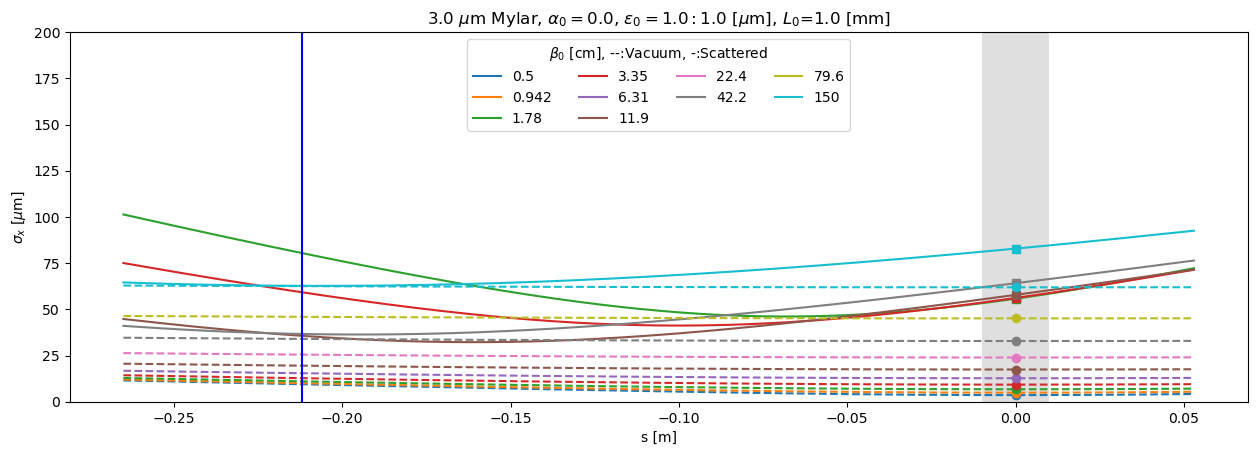

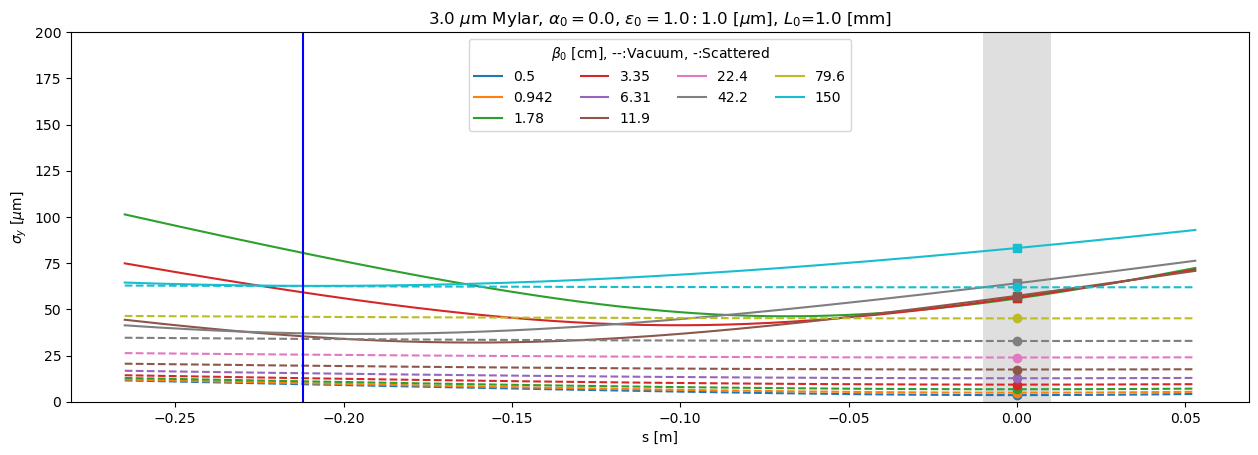

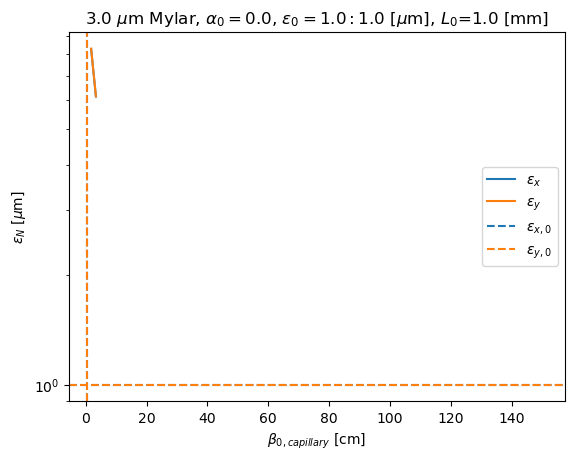

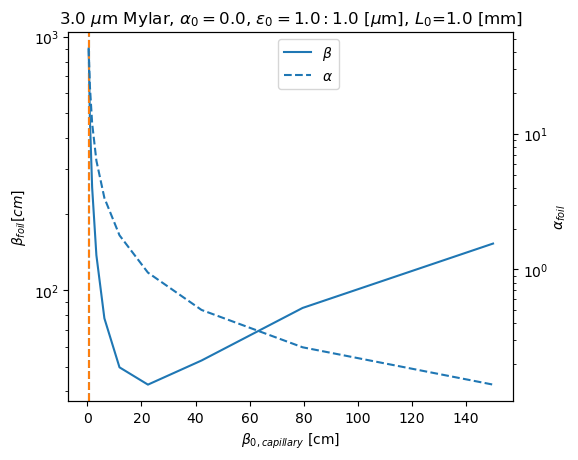

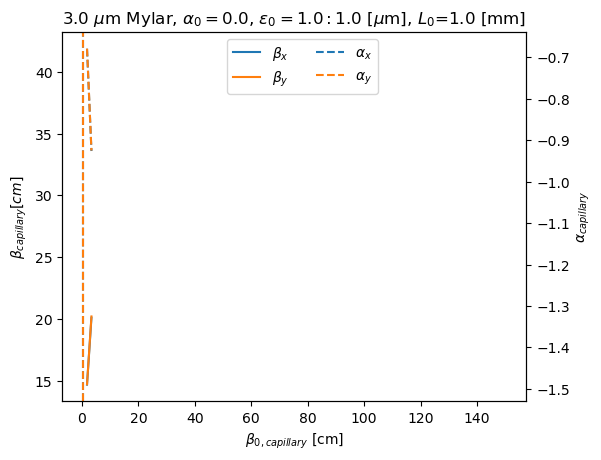

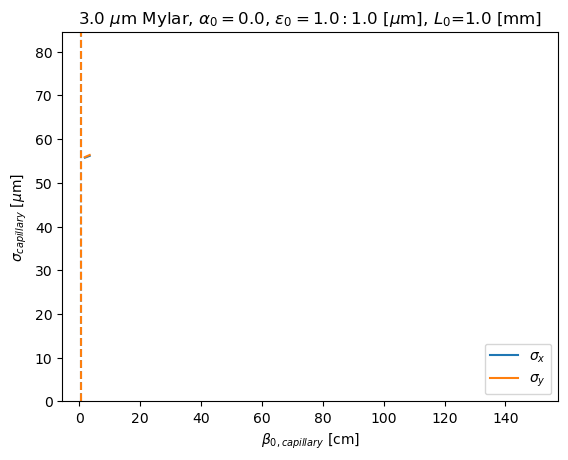

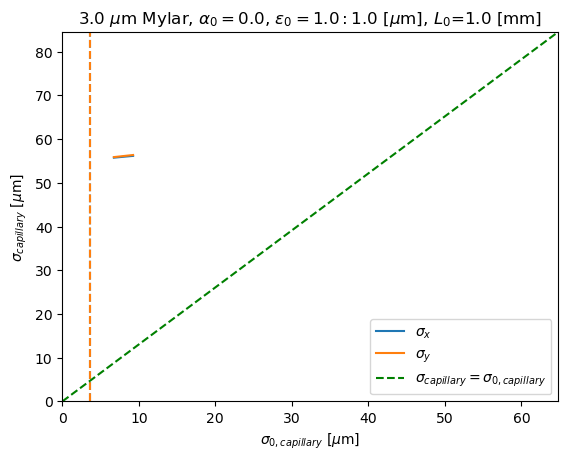

In [5]:
runSimulations(alpha_0=0.0,N=NUMEVENTS,N_beta=NUMBETA)

This shows what happens if we try to focus ON the lens, and then inserting the foil.
Smallest sigma is about 30 um.

Let's try to focus before the lens, i.e. alpha_0 < 1:

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=-1.0$, $\varepsilon_0 = 1.0:1.0$ [$\mu$m], $L_0$=1.0 [mm]'
gamma_rel = 391.3894324853229
beta_rel  = 0.9999967359821731

Making folder 'plots/beamParamScan_alpha0=-1.0_eps0=1.0:1.0_THICK=0.003_MAT=G4_MYLAR_Npoints=10'


Setting up simulation for beta_0 = 0.004999999999999999 [m] -> sigma_0 = 3.574219033294384 and 3.574219033294384 [um]

Setting up simulation for beta_0 = 0.009423358189215593 [m] -> sigma_0 = 4.906807389781633 and 4.906807389781633 [um]

Setting up simulation for beta_0 = 0.017759935912451334 [m] -> sigma_0 = 6.736229239488979 and 6.736229239488979 [um]

Setting up simulation for beta_0 = 0.03347164750410848 [m] -> sigma_0 = 9.247720719880475 and 9.247720719880475 [um]

Setting up simulation for beta_0 = 0.06308306472287568 [m] -> sigma_0 = 12.6955801936744 and 12.6955801936744 [um]

Setting up simulation for beta_0 = 0.11889086291142564 [m] -> sigma_0 = 17.428916955452884 and 17.428916955452884 [um]

Setting up simulation for be

/var/folders/qn/kznht2m95dv5l7mmd0kc_17c0000gp/T/ipykernel_74721/3045802714.py:171: RuntimeWarning: invalid value encountered in sqrt
  l1 = plt.plot(sPos,np.sqrt(eps_0x*beta0_s*1e6/(gamma_rel*beta_rel)), ls="--" )[0] # No-scatter sigma
/var/folders/qn/kznht2m95dv5l7mmd0kc_17c0000gp/T/ipykernel_74721/3045802714.py:181: RuntimeWarning: invalid value encountered in sqrt
  l1 = plt.plot(sPos,np.sqrt(eps_0y*beta0_s*1e6/(gamma_rel*beta_rel)), ls="--" )[0]  # No-scatter sigma


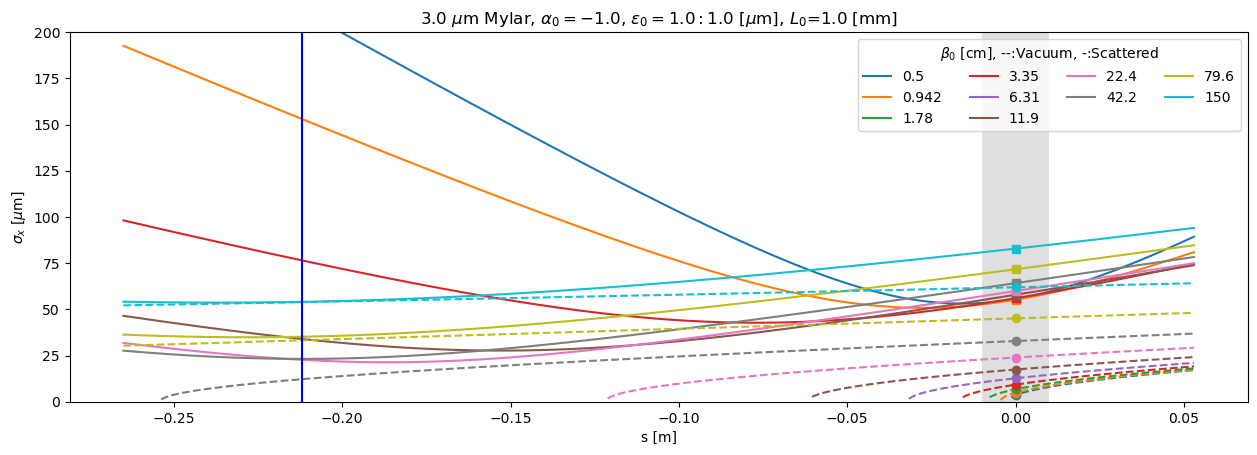

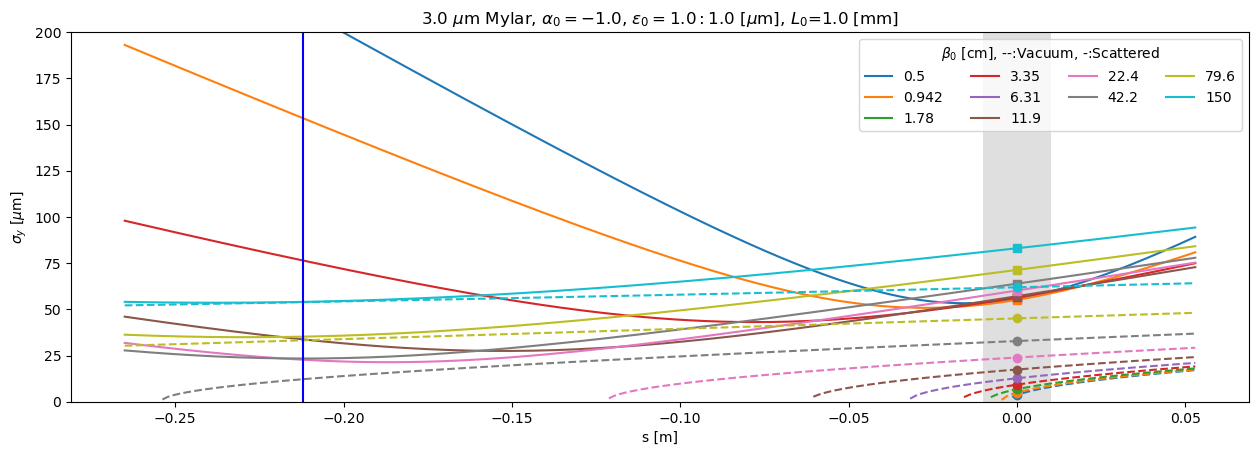

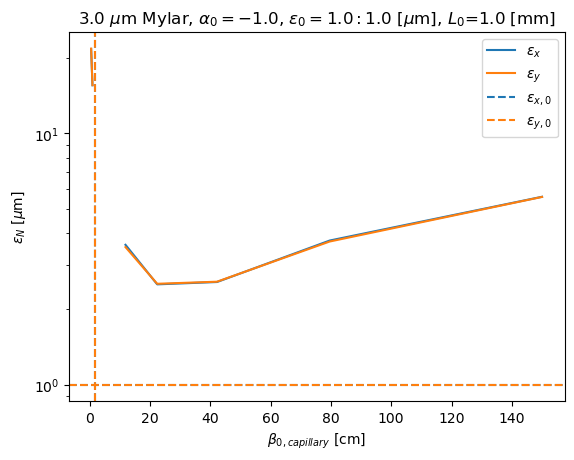

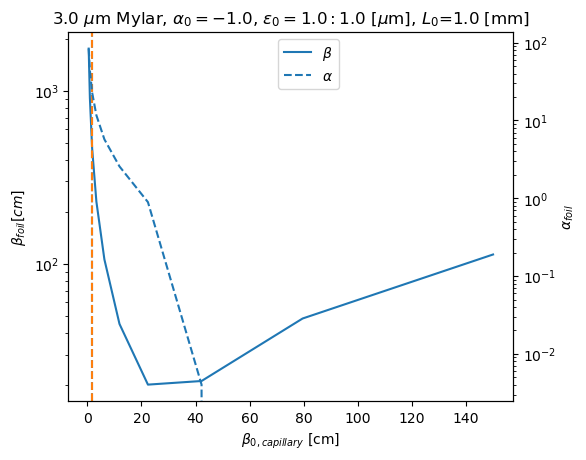

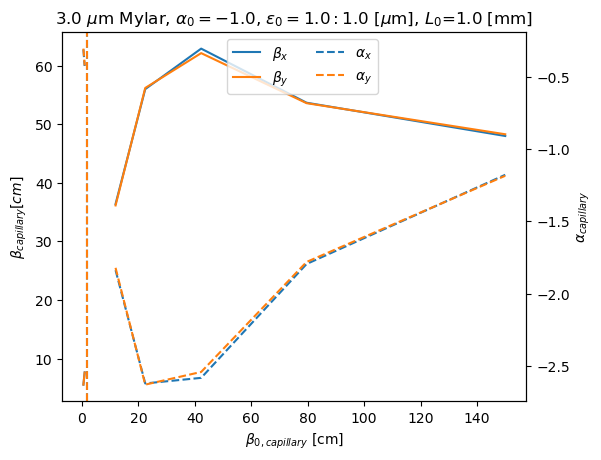

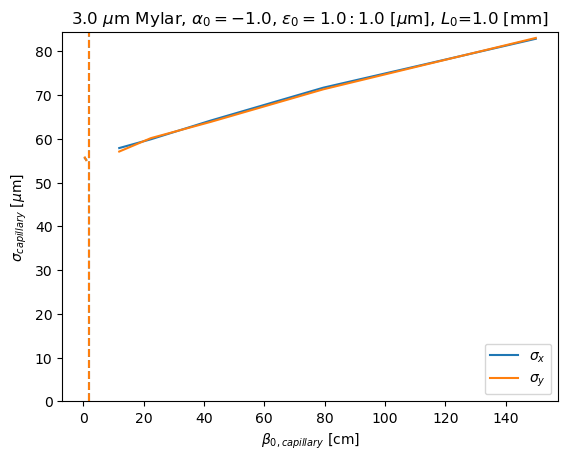

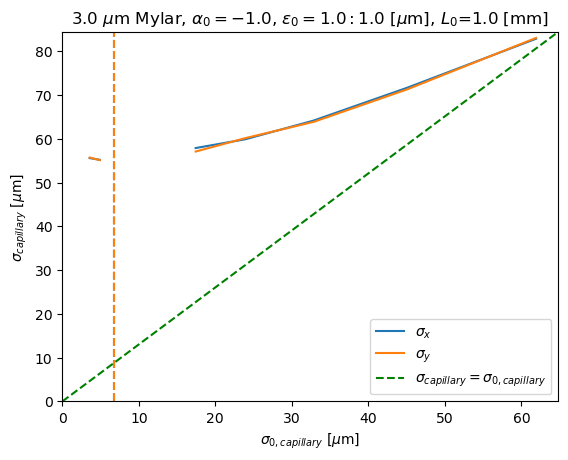

In [6]:
runSimulations(alpha_0=-1.0,N=NUMEVENTS,N_beta=NUMBETA)

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=0.0$, $\varepsilon_0 = 3.0:3.0$ [$\mu$m], $L_0$=3.0 [mm]'
gamma_rel = 391.3894324853229
beta_rel  = 0.9999967359821731

Making folder 'plots/beamParamScan_alpha0=0.0_eps0=3.0:3.0_THICK=0.003_MAT=G4_MYLAR_Npoints=10'


Setting up simulation for beta_0 = 0.004999999999999999 [m] -> sigma_0 = 6.19072896304559 and 6.19072896304559 [um]

Setting up simulation for beta_0 = 0.009423358189215593 [m] -> sigma_0 = 8.498839702056213 and 8.498839702056213 [um]

Setting up simulation for beta_0 = 0.017759935912451334 [m] -> sigma_0 = 11.66749129422597 and 11.66749129422597 [um]

Setting up simulation for beta_0 = 0.03347164750410848 [m] -> sigma_0 = 16.017522141040416 and 16.017522141040416 [um]

Setting up simulation for beta_0 = 0.06308306472287568 [m] -> sigma_0 = 21.989389927009192 and 21.989389927009192 [um]

Setting up simulation for beta_0 = 0.11889086291142564 [m] -> sigma_0 = 30.187769687743067 and 30.187769687743067 [um]

Setting up simulation for 

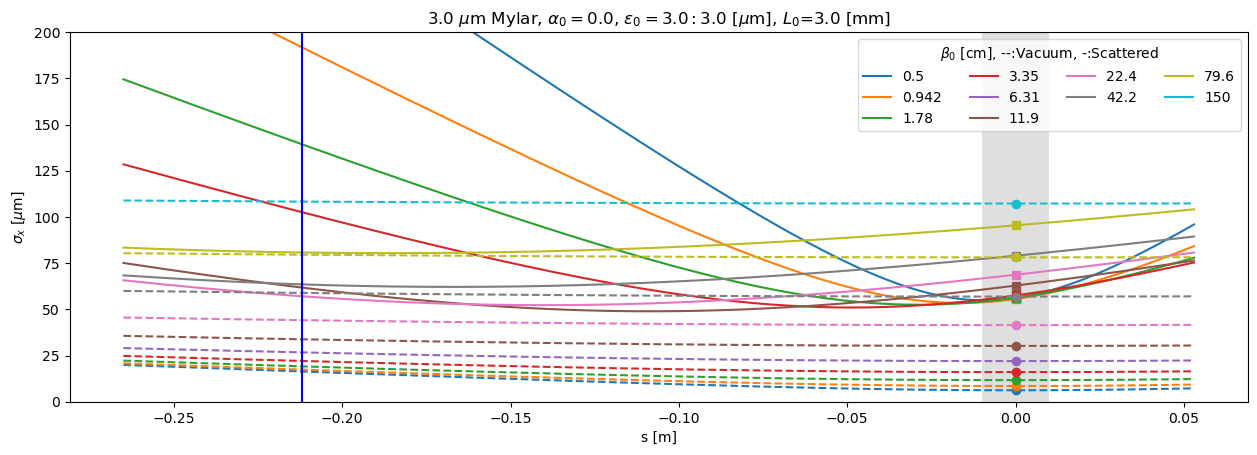

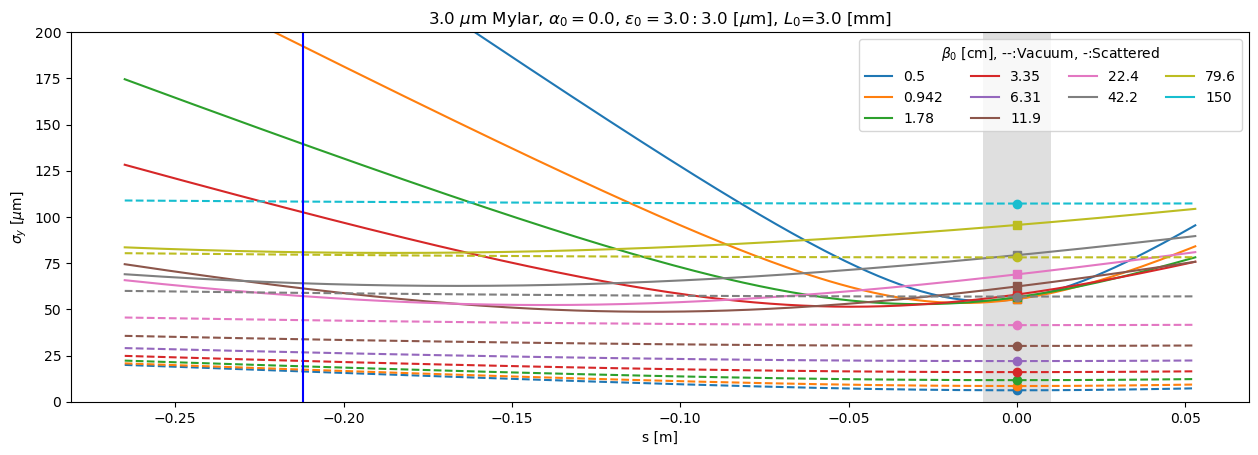

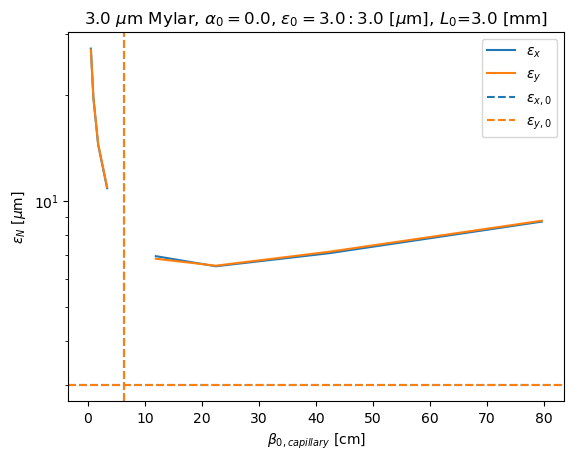

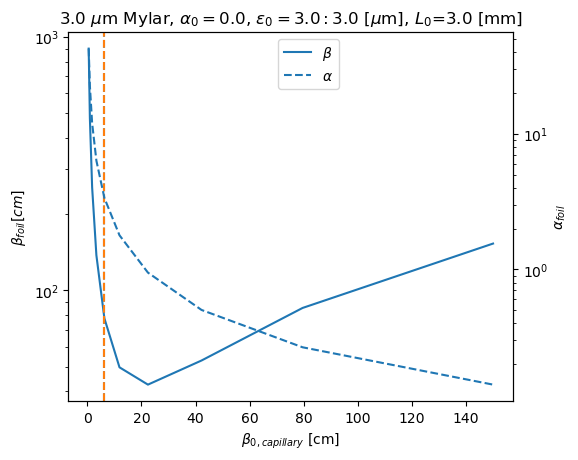

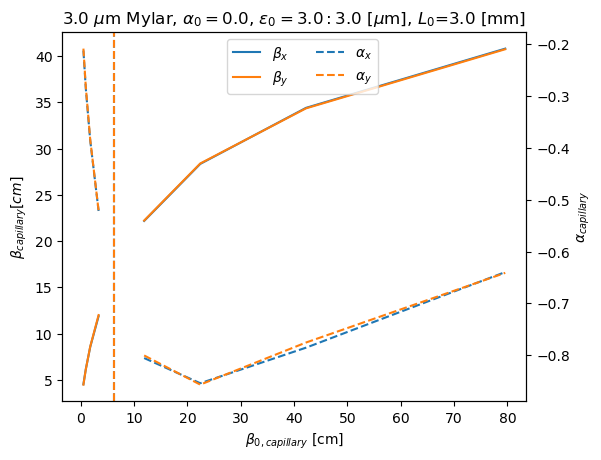

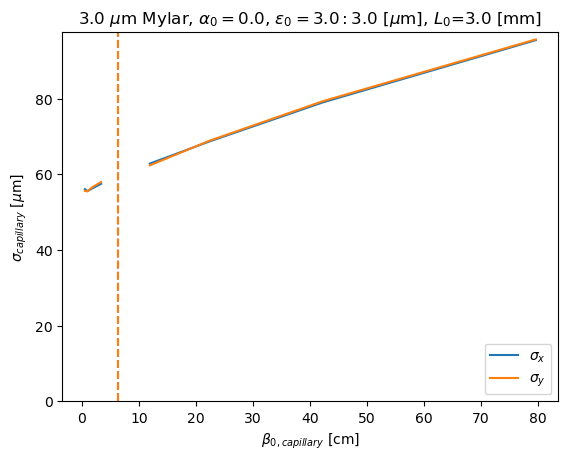

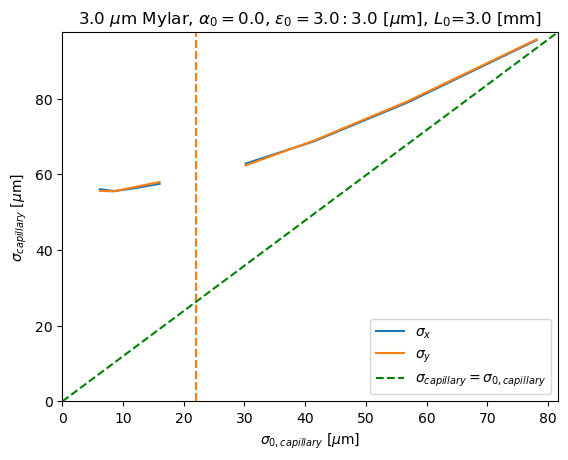

In [7]:
runSimulations(eps_0x=3.0, eps_0y=3.0, alpha_0=0.0,N=NUMEVENTS,N_beta=NUMBETA)

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=0.0$, $\varepsilon_0 = 5.0:5.0$ [$\mu$m], $L_0$=5.0 [mm]'
gamma_rel = 391.3894324853229
beta_rel  = 0.9999967359821731

Making folder 'plots/beamParamScan_alpha0=0.0_eps0=5.0:5.0_THICK=0.003_MAT=G4_MYLAR_Npoints=10'


Setting up simulation for beta_0 = 0.004999999999999999 [m] -> sigma_0 = 7.992196724919826 and 7.992196724919826 [um]

Setting up simulation for beta_0 = 0.009423358189215593 [m] -> sigma_0 = 10.97195487605004 and 10.97195487605004 [um]

Setting up simulation for beta_0 = 0.017759935912451334 [m] -> sigma_0 = 15.062666491519066 and 15.062666491519066 [um]

Setting up simulation for beta_0 = 0.03347164750410848 [m] -> sigma_0 = 20.67853216658603 and 20.67853216658603 [um]

Setting up simulation for beta_0 = 0.06308306472287568 [m] -> sigma_0 = 28.388180326855906 and 28.388180326855906 [um]

Setting up simulation for beta_0 = 0.11889086291142564 [m] -> sigma_0 = 38.97224308659133 and 38.97224308659133 [um]

Setting up simulation for 

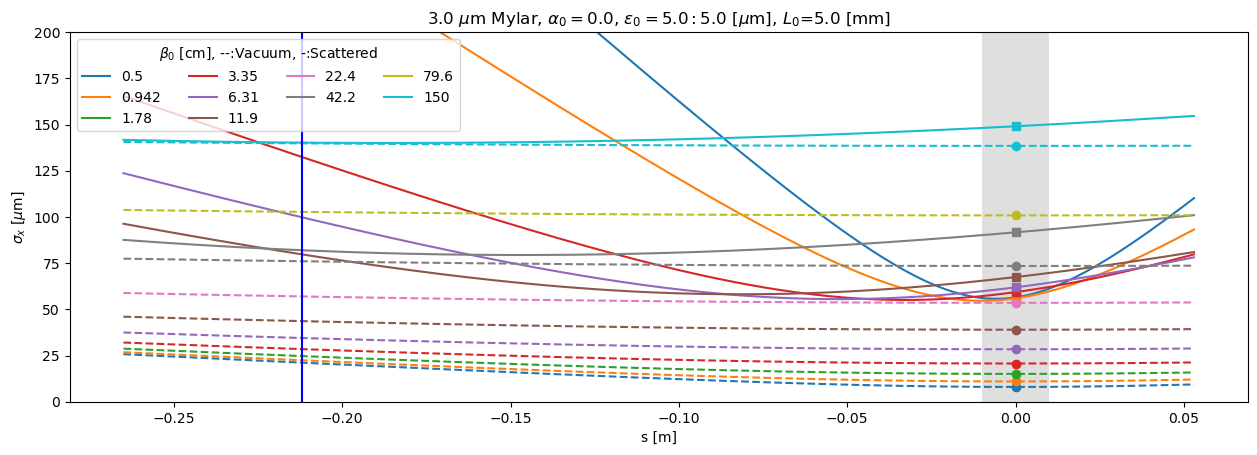

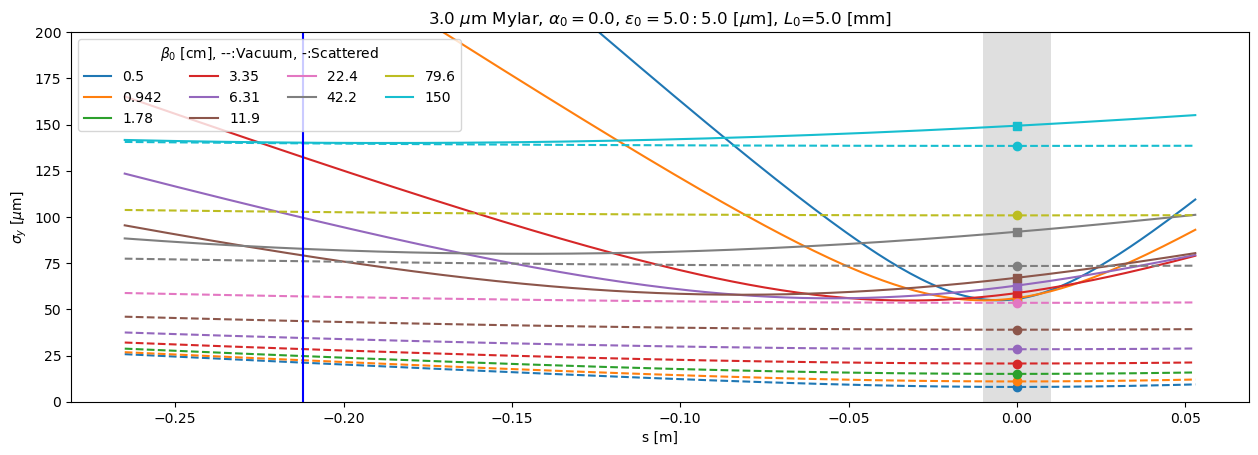

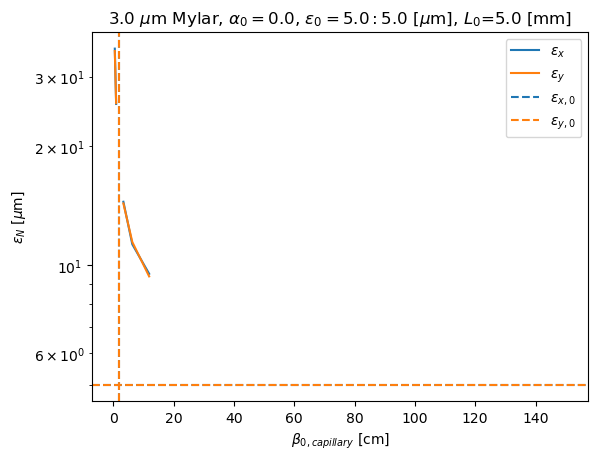

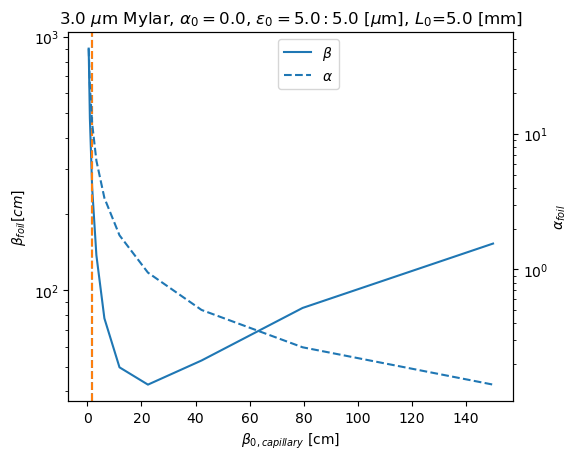

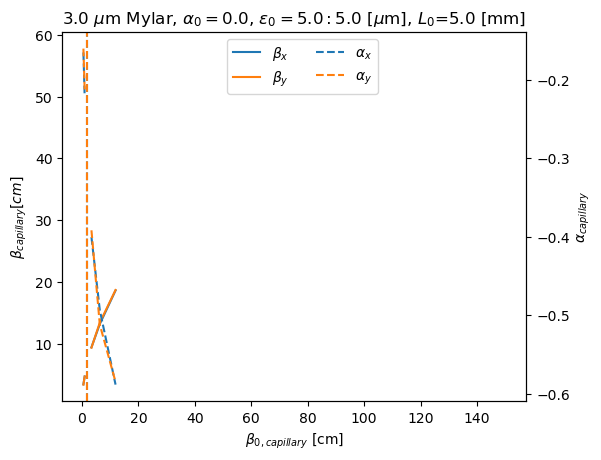

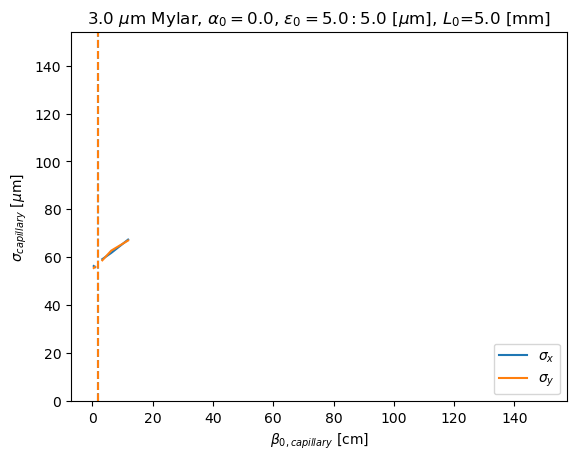

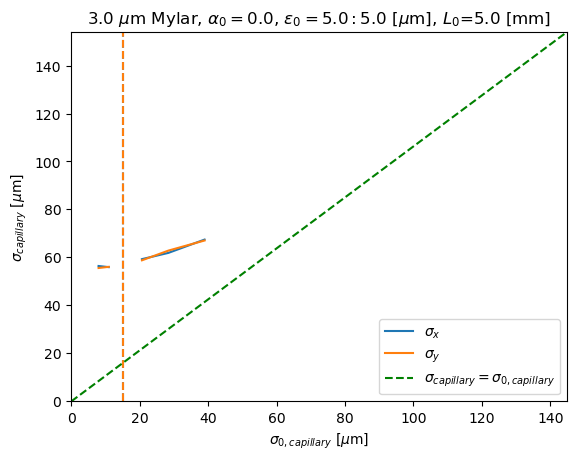

In [8]:
runSimulations(eps_0x=5.0, eps_0y=5.0, alpha_0=0.0,N=NUMEVENTS,N_beta=NUMBETA)

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=0.0$, $\varepsilon_0 = 10.0:1.0$ [$\mu$m], $L_0$=1.0 [mm]'
gamma_rel = 391.3894324853229
beta_rel  = 0.9999967359821731

Making folder 'plots/beamParamScan_alpha0=0.0_eps0=10.0:1.0_THICK=0.003_MAT=G4_MYLAR_Npoints=10'


Setting up simulation for beta_0 = 0.004999999999999999 [m] -> sigma_0 = 11.302673001535451 and 3.574219033294384 [um]

Setting up simulation for beta_0 = 0.009423358189215593 [m] -> sigma_0 = 15.516687391455577 and 4.906807389781633 [um]

Setting up simulation for beta_0 = 0.017759935912451334 [m] -> sigma_0 = 21.30182723780903 and 6.736229239488979 [um]

Setting up simulation for beta_0 = 0.03347164750410848 [m] -> sigma_0 = 29.243860639954264 and 9.247720719880475 [um]

Setting up simulation for beta_0 = 0.06308306472287568 [m] -> sigma_0 = 40.1469496293327 and 12.6955801936744 [um]

Setting up simulation for beta_0 = 0.11889086291142564 [m] -> sigma_0 = 55.11507472915854 and 17.428916955452884 [um]

Setting up simulation for 

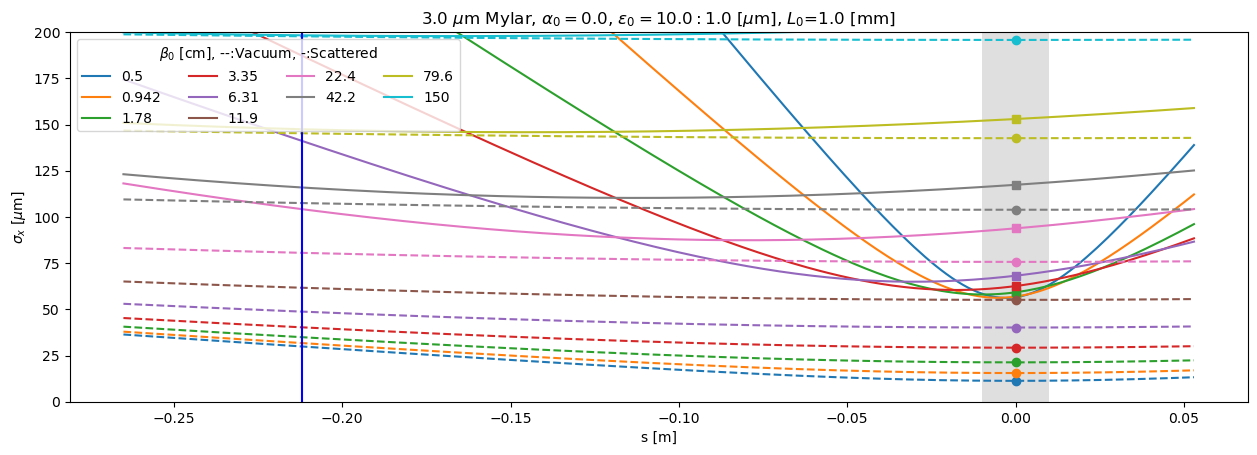

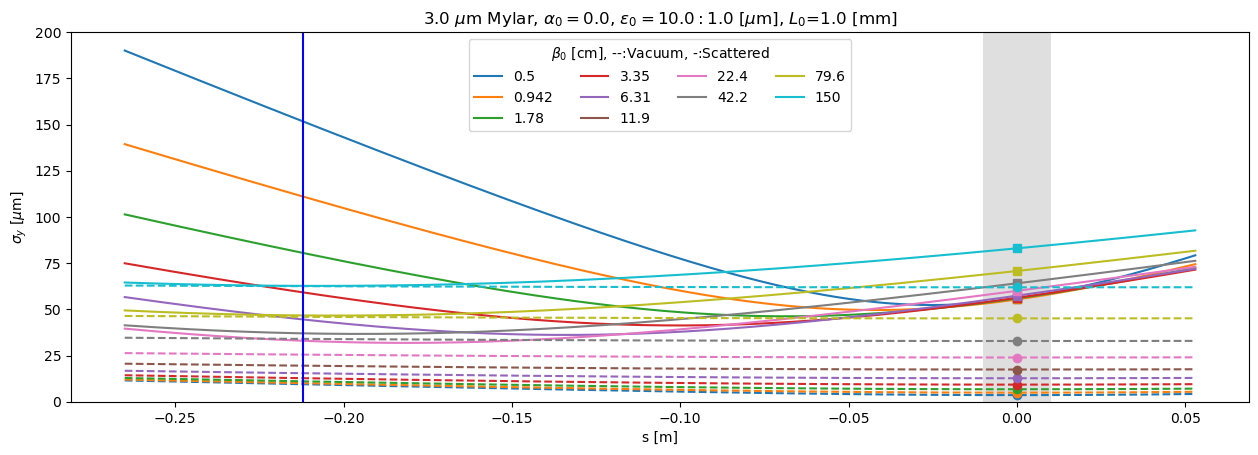

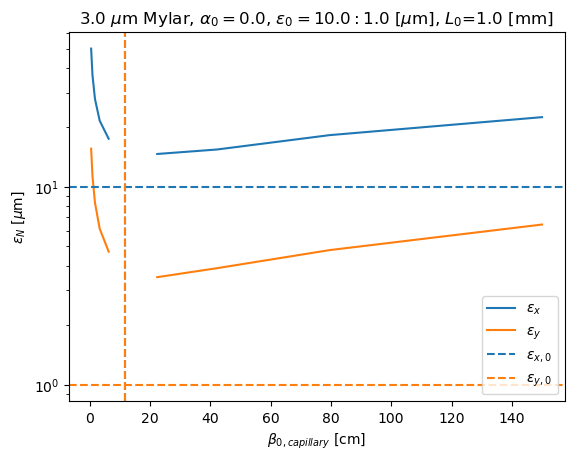

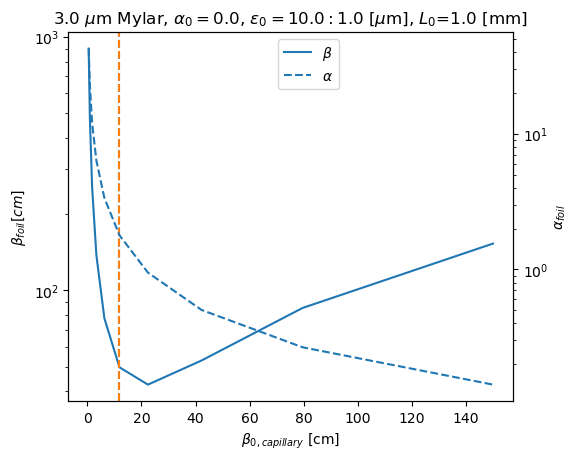

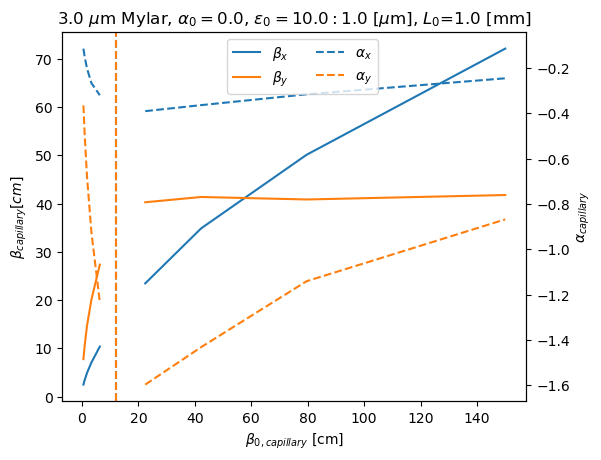

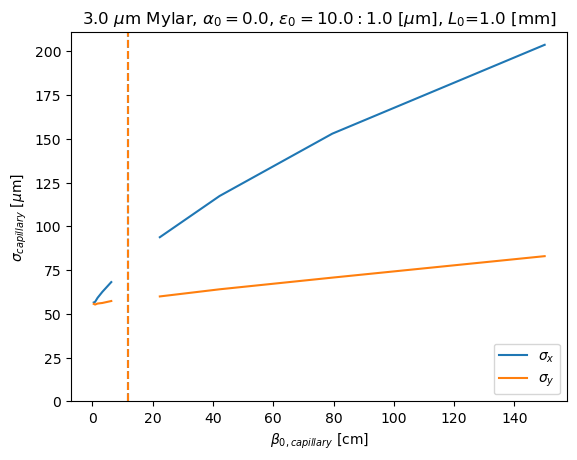

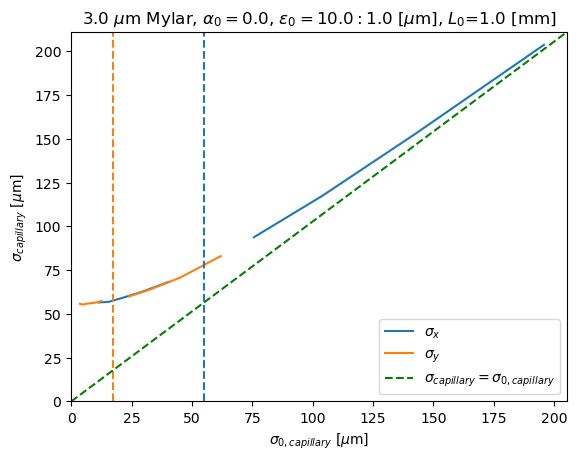

In [9]:
runSimulations(eps_0x=10.0, eps_0y=1.0, alpha_0=0.0,N=NUMEVENTS,N_beta=NUMBETA)